<a href="https://colab.research.google.com/github/sdamadi/Today-I-learned/blob/master/mnist_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-Layer Perceptron, MNIST

In [0]:
import torch
from torchvision import datasets # it is used to take advantage of Pytorch off-the-shelf datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [4]:
 # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels.shape)
images = images.numpy()
print(images.shape)

torch.Size([20])
(20, 1, 28, 28)


##Every sample that is obtained from `next` method contains a batch of images which is 20.

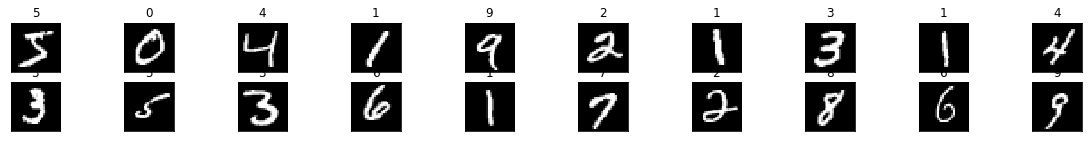

In [5]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 2))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[]) #nrows = 2 ncols = 20/2, index = idx + 1
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # squeez Remove single-dimensional entries from the shape of an array.
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

##View an Image in More Detail


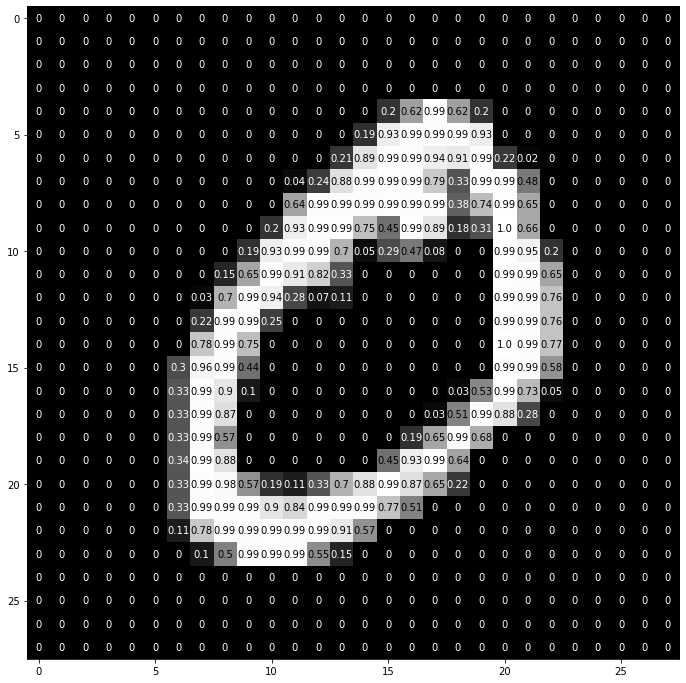

In [6]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

#Define the Network Architecture
The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [7]:
## Define the NN architecture
fc1_out = 10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, fc1_out)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(fc1_out, fc1_out)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(fc1_out, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data

        # self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
)


#Why do we have only one non-linear function in the above network?
Because ReLU is applied to the output of firts layer `fc1` and fed to `fc2`. Then `fc2` is applied to the output of `fc1` to generate the result with size 512. Apparently, here there is no nonlinearity. Finally, output of `fc3` should be passed in loss function. However, we know that from cross_entropy notes, converting them to probability vector using softmax has already implemented.

#Specify Loss Function and Optimizer
It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.

In [8]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
len(train_loader)

3000

#Train the Network
The steps for training/learning from a batch of data are described in the comments below:

1. Clear the gradients of all optimized variables
1. Forward pass: compute predicted outputs by passing inputs to the model
1. Calculate the loss
1. Backward pass: compute gradient of the loss with respect to model parameters
1. Perform a single optimization step (parameter update)
1. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [9]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.190321
Epoch: 2 	Training Loss: 0.797347
Epoch: 3 	Training Loss: 0.751587
Epoch: 4 	Training Loss: 0.729584
Epoch: 5 	Training Loss: 0.716300
Epoch: 6 	Training Loss: 0.707088
Epoch: 7 	Training Loss: 0.700369
Epoch: 8 	Training Loss: 0.694940
Epoch: 9 	Training Loss: 0.690460
Epoch: 10 	Training Loss: 0.686543
Epoch: 11 	Training Loss: 0.683040
Epoch: 12 	Training Loss: 0.679968
Epoch: 13 	Training Loss: 0.677034
Epoch: 14 	Training Loss: 0.674280
Epoch: 15 	Training Loss: 0.671848
Epoch: 16 	Training Loss: 0.669562
Epoch: 17 	Training Loss: 0.667456
Epoch: 18 	Training Loss: 0.665488
Epoch: 19 	Training Loss: 0.663638
Epoch: 20 	Training Loss: 0.661869
Epoch: 21 	Training Loss: 0.660089
Epoch: 22 	Training Loss: 0.658354
Epoch: 23 	Training Loss: 0.656770
Epoch: 24 	Training Loss: 0.655249
Epoch: 25 	Training Loss: 0.653773
Epoch: 26 	Training Loss: 0.652377
Epoch: 27 	Training Loss: 0.650978
Epoch: 28 	Training Loss: 0.649565
Epoch: 29 	Training Loss: 0.6

#Test the Trained Network
Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

**model.eval()** will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [10]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.655125

Test Accuracy of     0: 98% (964/980)
Test Accuracy of     1: 98% (1116/1135)
Test Accuracy of     2: 90% (932/1032)
Test Accuracy of     3: 92% (938/1010)
Test Accuracy of     4: 92% (904/982)
Test Accuracy of     5: 89% (802/892)
Test Accuracy of     6:  0% ( 0/958)
Test Accuracy of     7: 92% (955/1028)
Test Accuracy of     8:  0% ( 0/974)
Test Accuracy of     9: 93% (946/1009)

Test Accuracy (Overall): 75% (7557/10000)


#Visualize Sample Test Results
This cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

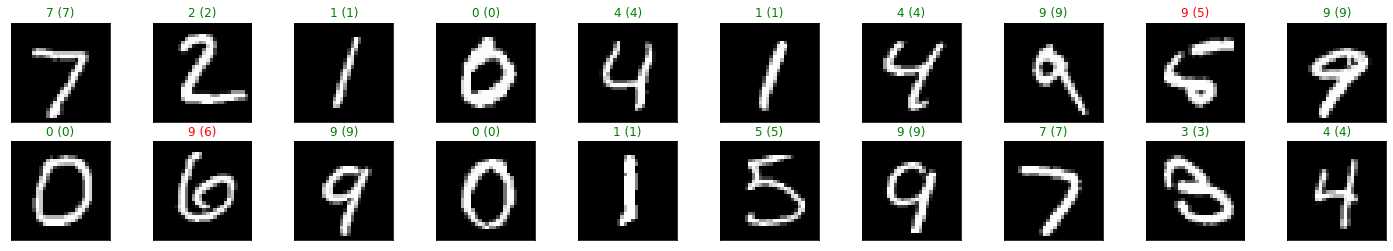

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

#Counting the number of parameters


In [0]:
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round((nonzero/total)*100,1))

In [13]:
print_nonzeros(model)

fc1.weight           | nonzeros =    7840 /    7840 (100.00%) | total_pruned =       0 | shape = (10, 784)
fc1.bias             | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
fc2.weight           | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (10, 10)
fc2.bias             | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
fc3.weight           | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (10, 10)
fc3.bias             | nonzeros =      10 /      10 (100.00%) | total_pruned =       0 | shape = (10,)
alive: 8070, pruned : 0, total: 8070, Compression rate :       1.00x  (  0.00% pruned)


100.0